In [1]:
# Import libs
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

In [2]:
# load dataset
X = np.load(r'C:\Users\JHL\F21DL\smiley_X.npy')
y = np.load(r'C:\Users\JHL\F21DL\smiley_y.npy')

In [3]:
# reshape X
print("The original shape of X: ", X.shape)
X = X.reshape((X.shape[0], -1))
print("The shape of X after reshaping: ", X.shape)

The original shape of X:  (144, 9, 9, 1)
The shape of X after reshaping:  (144, 81)


In [4]:
# examine the number of samples in each class
for label in np.unique(y):
    print(f"The number of samples in calss {label}: {sum(y==label)}")

The number of samples in calss 0.0: 72
The number of samples in calss 1.0: 72


## Decision Tree
1. Use Decision trees (the J48/C4.5 algorithm) on a training set, measure the accuracy. Then measure the accuracy using 10-fold cross-validataion on the training set. (If you are dealing with an unbalanced dataset, what else should you consider when doing the train/test split?)
2. Experiment with various decision tree parameters that control the size of the tree. For example: depth of the tree, confidence threshold for pruning, splitting criteria and the minimal number of instances permissible per leaf.
3. Put all your results in a suitable form. (a table or a series of graphs)
4. Using the best working parameters, repeat the experiment, this time using training and testing data sets instead of the cross validation. Answer the question: Does the decision tree generalize well to new data? How do you tell?
5. Try some other decision tree algorithms (e.g. random forests). Repeat all of the above experiments and make conclusions.

### 1. Use Decision Tree 
- Explanation of the choice of classifier: 
    - The scikit-learn uses an optimized version of the **CART algorithm**, which is very similar to C4.5 but differs in that it supports numerical target variables (regression) and does not compute rule sets. (https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart)
    - Because we are doing classification, the scikit-learn Decision Tree would be fine
- Explanation of the choice of initial parameters:
    - It is recommended to set `max_depth=3` and `min_samples_leaf=5` (1.10.5. Tips on practical use)
    - But when used `max_depth=3`, accuracy both on the training set and on the test set was 1, so For the analyzing purpose, reduced to `max_depth=2`.
- What else should you consider when doing the tran/test split, if using unbalanced dataset?: 
    - One of the disadvantages of the Decision tree is that it creates biased trees if some classes dominate. 
    - So, data should be balanceed prior to fitting with the decision tree.
    - In case of our dataset, it is balanced (no need pre-processing)

In [5]:
# train/test set split
# test set size: 44, train set size: 100 (for 10-fold cross-validation)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=44, random_state=42)
print(X_train.shape)
print(X_test.shape)

(100, 81)
(44, 81)


In [6]:
# fit tree
from sklearn.tree import DecisionTreeClassifier,plot_tree
initial_tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)
initial_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

[Text(0.6, 0.8333333333333334, 'X[40] <= 0.5\ngini = 0.499\nsamples = 100\nvalue = [48, 52]'),
 Text(0.4, 0.5, 'X[48] <= 0.5\ngini = 0.45\nsamples = 73\nvalue = [48, 25]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.0\nsamples = 39\nvalue = [39, 0]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.389\nsamples = 34\nvalue = [9, 25]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 27\nvalue = [0, 27]')]

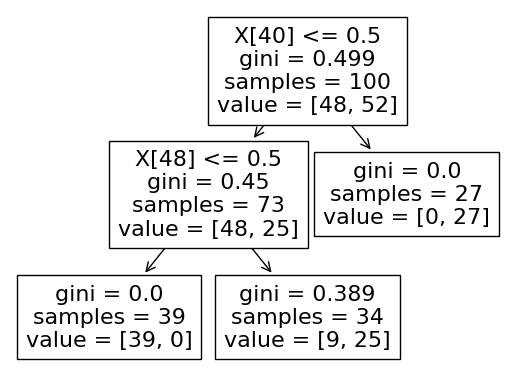

In [7]:
plot_tree(initial_tree)

In [8]:
# Accuracy measure
pred_train = initial_tree.predict(X_train)
pred_test = initial_tree.predict(X_test)
print("Accuracy on training set: ", sum(pred_train == y_train) / len(pred_train == y_train))
print("Accuracy on test set    : ", sum(pred_test == y_test) / len(pred_test == y_test))

Accuracy on training set:  0.91
Accuracy on test set    :  0.9318181818181818


[0.9 1.  0.9 1.  0.9 0.8 0.9 1.  0.9 0.8]


Text(0, 0.5, 'Cross validation Score')

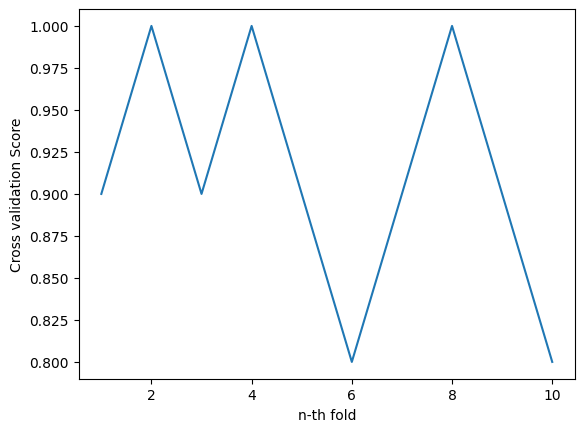

In [9]:
# Measure the accuracy using 10-fold cross-validation on the training set
from sklearn.model_selection import cross_val_score
scores = cross_val_score(initial_tree, X_train, y_train, cv=10, scoring="accuracy")
print(scores)

# plotting scores
x = np.linspace(1, 10, 10)
plt.plot(x, scores)
plt.xlabel("n-th fold")
plt.ylabel("Cross validation Score")

In [10]:
# implement 10-fold cross-validation manually and evaluate it using major matics 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score

# make data from for evaluation 
columns = ['Accuracy', 'TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'Area Under RoC Curve']
tenFold_evaluation = pd.DataFrame(columns = columns)
tenFold_evaluation

# split data into 10 groups
from sklearn.model_selection import StratifiedKFold
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)

for k, (train, test) in enumerate(kfold):
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)
    tree.fit(X_train[train], y_train[train])
    pred = tree.predict(X_train[test])
    accuracy = sum(pred==y_train[test]) / len(pred)
    cm = confusion_matrix(y_train[test], pred)
    tp, fp, tn, fn = cm[1,1], cm[0,1], cm[0,0], cm[1,0]
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    precision = precision_score(y_train[test], pred)
    recall = recall_score(y_train[test], pred)
    auc = roc_auc_score(pred, y_train[test])
    
    index = str(k+1) + "fold"
    tenFold_evaluation.loc[index] = [accuracy, tp, fp, tn, fn, sensitivity, specificity, precision, recall, auc]

tenFold_evaluation

,Accuracy,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,Area Under RoC Curve
1fold,0.9,5.0,1.0,4.0,0.0,1.0,0.80,0.833333,1.0,0.916667
2fold,1.0,5.0,0.0,5.0,0.0,1.0,1.00,1.000000,1.0,1.000000
3fold,0.9,5.0,1.0,4.0,0.0,1.0,0.80,0.833333,1.0,0.916667
4fold,1.0,5.0,0.0,5.0,0.0,1.0,1.00,1.000000,1.0,1.000000
5fold,0.9,5.0,1.0,4.0,0.0,1.0,0.80,0.833333,1.0,0.916667
6fold,0.8,5.0,2.0,3.0,0.0,1.0,0.60,0.714286,1.0,0.857143
7fold,0.9,5.0,1.0,4.0,0.0,1.0,0.80,0.833333,1.0,0.916667
8fold,1.0,5.0,0.0,5.0,0.0,1.0,1.00,1.000000,1.0,1.000000
9fold,0.9,6.0,1.0,3.0,0.0,1.0,0.75,0.857143,1.0,0.928571
10fold,0.8,6.0,2.0,2.0,0.0,1.0,0.50,0.750000,1.0,0.875000


### 2. Experiment with parameters

In [11]:
# using sklearn RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'max_depth': randint(low=1, high=3), # with depth 3, it learn 100% accurate
    'min_samples_split': randint(low=2, high=10),
    'min_samples_leaf' : randint(low=1, high=10),
    'min_impurity_decrease' : np.linspace(0, 1, 11)
    }

tree = DecisionTreeClassifier(random_state=42)
rnd_search = RandomizedSearchCV(tree, param_distributions=param_distribs,
                                n_iter=50, cv=10, scoring='accuracy', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000219ABE5B4C0>,
                                        'min_impurity_decrease': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000219ABE590C0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000219ABE58190>},
                   random_state=42, scoring='accuracy')

In [12]:
# result as a dataframe
result = pd.DataFrame(rnd_search.cv_results_)
print(result.columns)
result[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_impurity_decrease',
       'param_min_samples_leaf', 'param_min_samples_split', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


,params,mean_test_score,std_test_score,rank_test_score
21,"{'max_depth': 2, 'min_impurity_decrease': 0.1,...",0.91,0.07000,1
29,"{'max_depth': 2, 'min_impurity_decrease': 0.1,...",0.91,0.07000,1
40,"{'max_depth': 2, 'min_impurity_decrease': 0.1,...",0.91,0.07000,1
49,"{'max_depth': 1, 'min_impurity_decrease': 0.0,...",0.75,0.10247,4
23,"{'max_depth': 1, 'min_impurity_decrease': 0.0,...",0.75,0.10247,4
32,"{'max_depth': 1, 'min_impurity_decrease': 0.0,...",0.75,0.10247,4
18,"{'max_depth': 1, 'min_impurity_decrease': 0.1,...",0.75,0.10247,4
15,"{'max_depth': 1, 'min_impurity_decrease': 0.0,...",0.75,0.10247,4
12,"{'max_depth': 1, 'min_impurity_decrease': 0.1,...",0.75,0.10247,4
13,"{'max_depth': 1, 'min_impurity_decrease': 0.1,...",0.75,0.10247,4


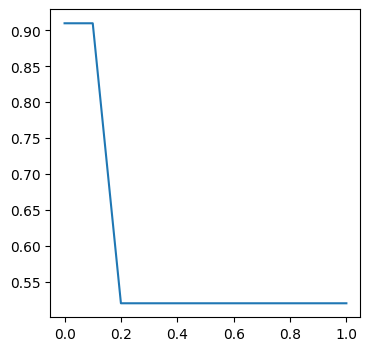

In [13]:
# fix other params, explore min_impurity_decrease
params_impurity = np.linspace(0, 1, 11)
scores_impurity = np.zeros(11)
for i, param in enumerate(params_impurity):
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, min_impurity_decrease=param)
    cvScore = cross_val_score(tree, X_train, y_train, cv=10, scoring="accuracy")
    scores_impurity[i] = cvScore.mean()
plt.figure(figsize=(4, 4))
plt.plot(params_impurity, scores_impurity)

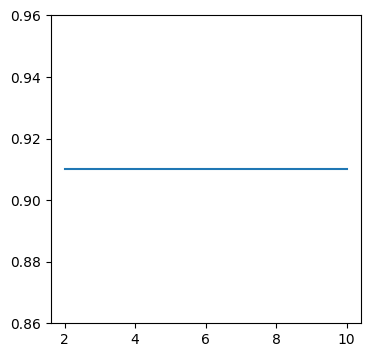

In [14]:
# fix other params, explore min_samples_split
params_split = np.linspace(2, 10, 9)
scores_split = np.zeros(9)
for i, param in enumerate(params_split):
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, min_samples_split=int(param))
    cvScore = cross_val_score(tree, X_train, y_train, cv=10, scoring="accuracy")
    scores_split[i] = cvScore.mean()
plt.figure(figsize=(4, 4))
plt.plot(params_split, scores_split)

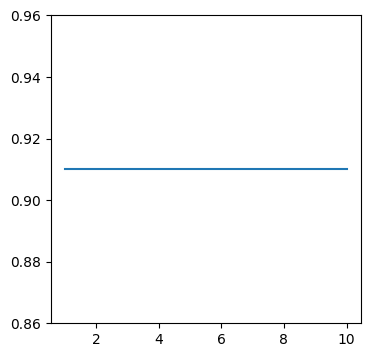

In [15]:
# fix other params, explore min_samples_leaf
params_leaf = np.linspace(1, 10, 10)
scores_leaf = np.zeros(10)
for i, param in enumerate(params_leaf):
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=int(param))
    cvScore = cross_val_score(tree, X_train, y_train, cv=10, scoring="accuracy")
    scores_leaf[i] = cvScore.mean()
plt.figure(figsize=(4, 4))
plt.plot(params_leaf, scores_leaf)

### 3. Put all your results in a suitable form

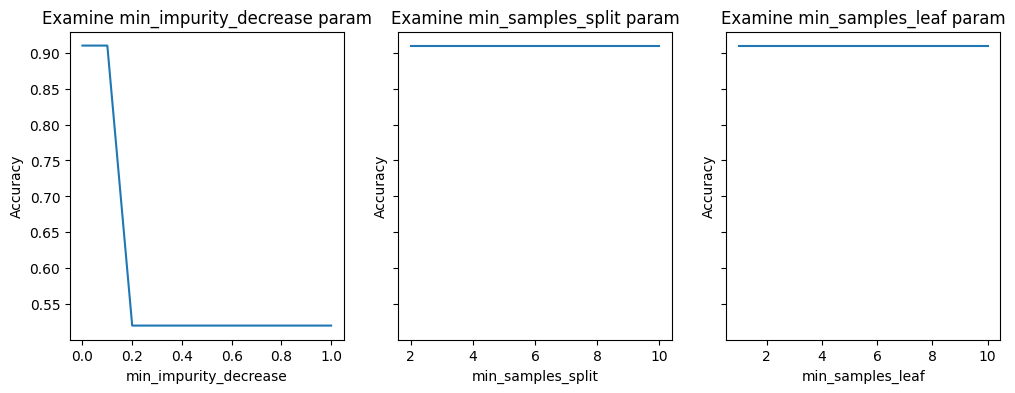

In [16]:
# plot graphs altogether
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

plt.sca(axes[0])
plt.plot(params_impurity, scores_impurity)
plt.xlabel("min_impurity_decrease")
plt.ylabel("Accuracy")
plt.title("Examine min_impurity_decrease param")

plt.sca(axes[1])
plt.plot(params_split, scores_split)
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.title("Examine min_samples_split param")

plt.sca(axes[2])
plt.plot(params_leaf, scores_leaf)
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title("Examine min_samples_leaf param")

plt.show()

### 4. Using the best parameters experiment test sets (Use three different train/test split)

In [17]:
# find best parameters found by RandomizedSearchCV
best_params = result.sort_values('rank_test_score')[['params']].iloc[0]['params']
for k, v in best_params.items():
    print(f"best {k}: {best_params[k]}")

best max_depth: 2
best min_impurity_decrease: 0.1
best min_samples_leaf: 5
best min_samples_split: 9


In [18]:
tree = DecisionTreeClassifier(
    max_depth=2, 
    min_impurity_decrease=0.1,
    min_samples_leaf=5,
    min_samples_split=9)

def accuracy_report(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)

    accuracy_train = sum(pred_train==y_train) / len(y_train)
    accuracy_test = sum(pred_test==y_test) / len(y_test)

    print("Accuracy on the train set: ", accuracy_train)
    print("Accuracy on the set   set: ", accuracy_test)

In [19]:
accuracy_report(tree, X_train, X_test, y_train, y_test)

Accuracy on the train set:  0.91
Accuracy on the set   set:  0.9318181818181818


- Does the decision tree generalize well to new data? How do you tell?
    - It generalizes well to new data.
    - It has higher accuracy on the test set than on the train set. It means the classifier works well with unseed data.

In [20]:
# Tree 2 (move 30% of the instances from the original training set into the testing set)
# test set size: 74, train set size: 70 (for 10-fold cross-validation)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=74, random_state=42)
print(X_train.shape)
print(X_test.shape)
accuracy_report(tree, X_train, X_test, y_train, y_test)

(70, 81)
(74, 81)
Accuracy on the train set:  0.9
Accuracy on the set   set:  0.9324324324324325


In [21]:
# Tree 3 (move 60% of the instances from the original training set into the testing set)
# test set size: 104, train set size: 40 (for 10-fold cross-validation)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=104, random_state=42)
print(X_train.shape)
print(X_test.shape)
accuracy_report(tree, X_train, X_test, y_train, y_test)

(40, 81)
(104, 81)
Accuracy on the train set:  0.925
Accuracy on the set   set:  0.9134615384615384


### 5. Try other decision tree algorithms

In [22]:
# Random forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

In [23]:
# experiments with parameters 
param_distribs = {
    'n_estimators': randint(low=2, high=100), # default=100
    'max_depth' : [2] # set to 2
    }

rnd_search = RandomizedSearchCV(forest, param_distributions=param_distribs,
                                n_iter=100, cv=10, scoring='accuracy', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [2],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000219AD07BF10>},
                   random_state=42, scoring='accuracy')

In [24]:
# result as a dataframe
result = pd.DataFrame(rnd_search.cv_results_)
result[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
23,"{'max_depth': 2, 'n_estimators': 34}",0.950,0.100000,1
82,"{'max_depth': 2, 'n_estimators': 75}",0.950,0.100000,1
84,"{'max_depth': 2, 'n_estimators': 15}",0.950,0.100000,1
11,"{'max_depth': 2, 'n_estimators': 25}",0.950,0.100000,1
92,"{'max_depth': 2, 'n_estimators': 41}",0.950,0.100000,1
...,...,...,...,...
72,"{'max_depth': 2, 'n_estimators': 7}",0.850,0.200000,96
15,"{'max_depth': 2, 'n_estimators': 3}",0.850,0.165831,96
70,"{'max_depth': 2, 'n_estimators': 5}",0.850,0.200000,96
57,"{'max_depth': 2, 'n_estimators': 3}",0.850,0.165831,96


In [25]:
# find best params
best_params = result.sort_values('rank_test_score')[['params']].iloc[0]['params']
for k, v in best_params.items():
    print(f"best {k}: {best_params[k]}")

best max_depth: 2
best n_estimators: 34


In [28]:
# try three different train/test split
test_sizes = [44, 74, 104]
forest = RandomForestClassifier(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'])
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print(f"Accuracy test with train size {X.shape[0]-test_size} and test size {test_size}")
    accuracy_report(forest, X_train, X_test, y_train, y_test)

Accuracy test with train size 100 and test size 44
Accuracy on the train set:  0.96
Accuracy on the set   set:  1.0
Accuracy test with train size 70 and test size 74
Accuracy on the train set:  1.0
Accuracy on the set   set:  1.0
Accuracy test with train size 40 and test size 104
Accuracy on the train set:  0.925
Accuracy on the set   set:  0.9134615384615384


### 6. Discussion (During the lab)

1. Make conclusions about our experiments with tuning parameters of the decision trees. What was the influence of various parameters on the classifier’s performance? Hypothesise why.
    - With only max depth of 3, it brings 100% accuracy on the face dataset. To prevent overfitting, we restricted this as maximum of 2. Depth 2 showed highest accuracy, of course. 
    - Regarding minimum impurity decrease, 0.0 (the default value) and 0.1 showed same performance, but accuracy decreased when we set to be higher than or same as 0.2. The result is quite reasonable because the higher the minimum impurity decrease is, the less sensitive the tree would be. 
    - Minimum samples of leaf and minimum samples of splits did not show any different on the accuracy. It seems that it is because the dataset is relatively small and less diverse.
    - RandomForest showed better performance in general as expected. This is because the forest uses  several different trees (n_estimators) and this makes the forest prediction more stable than a stochastic tree. 

2. Analyse Tree 1, Tree 2 and Tree 3 from the point of view of the problem of classifier overfitting. Do you notice the effects of over-fitting? How? Note your conclusions in the Jupyter notebook. (Note: to make conclusions about overfitting, you must compare accuracies of your three decision trees on training and on testing data sets.)
    - Results from the experiment with different train/test sizes are below table.

| Train set size | Test set size | Accuracy on train set | Accuracy on test set |
| -------------- | ------------- | --------------------- | -------------------- |
| 100            | 44            | 0.96                  | 1.0                  |
| 70             | 74            | 1.0                   | 1.0                  |
| 40             | 104           | 0.925                 | 0.9134615384         |


    - It is known that there are more possibilities to have overfitted estimator when we have too many training examples in general, but it is not observed in our case. (probably because it is quite simple datasets to learn) 
    - One notable fact is that with smallest train set size (40) the accuracy decreased. It seems that this is because 40 is too small for the tree to learn enough. 
